In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir           = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]



In [3]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [4]:
counts_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df             = counts_ward_df.reset_index(drop=True)
buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-01')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df  = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop            = H.mean(axis=1)
num_pop        = len(pop)
building_names = pop.index

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3934737986.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()


In [5]:
selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:
        return "Rest"

buildings_df["building2"] = buildings_df.apply(lambda x: building2building(x.building), axis=1)
buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/4015144701.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/4015144701.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/89720003.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df = buildings_plt_df.groupby(['date']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/89720003.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  b_df        = b_df.set_index("date").resample("W-Sun").sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/89720003.py:36: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to Fal

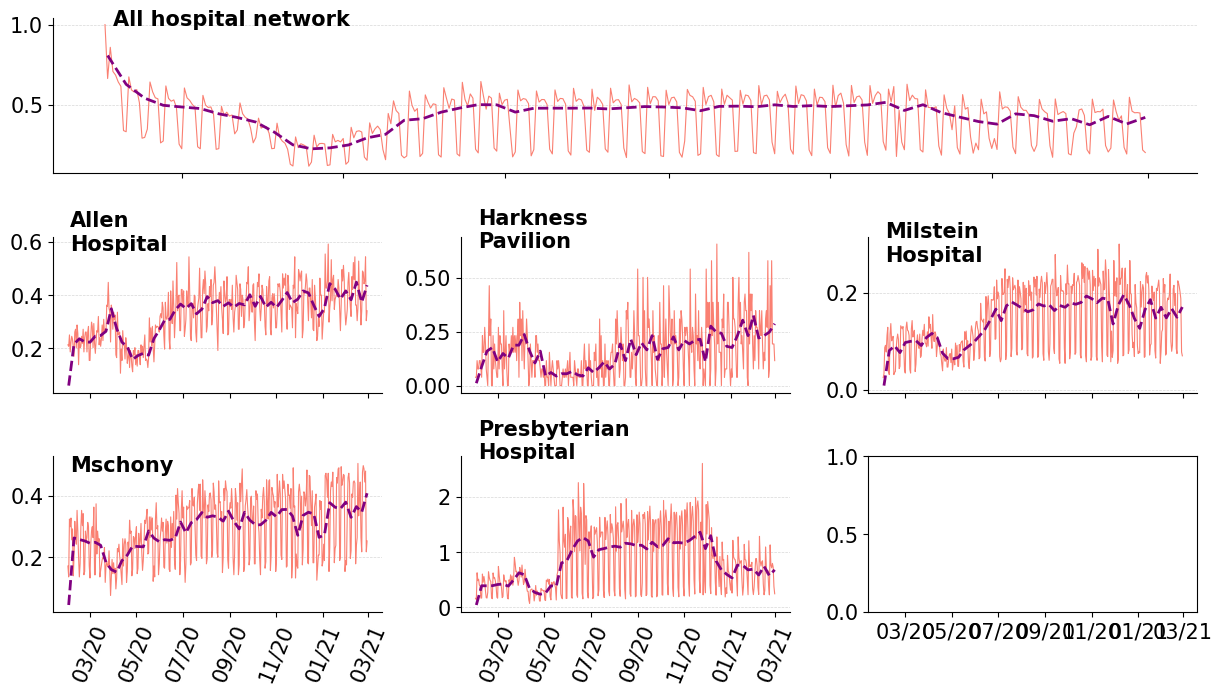

In [23]:
from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt


fig, axes = plt.subplot_mosaic([["hospital", "hospital", "hospital"],
                               [selected_buildings[0], selected_buildings[1], selected_buildings[2]],
                               [selected_buildings[3], selected_buildings[4], selected_buildings[5]]],
                              figsize=(12.5, 7.2), sharex=True, sharey=False)

hosp_df = buildings_plt_df.groupby(['date']).sum().reset_index()
axes["hospital"].plot(hosp_df.date, hosp_df.num_admitted / hosp_df.num_hospitalized, color="salmon", lw=0.8)
#axes["hospital"].plot(hosp_df.date, hosp_df.num_discharged / hosp_df.num_hospitalized, color="dodgerblue", lw=0.8)

hosp_df        = hosp_df.set_index("date").resample("W-Sun").sum().reset_index()
axes["hospital"].plot(hosp_df.date, hosp_df.num_admitted / hosp_df.num_hospitalized, color="purple", lw=2, ls="--")

axes["hospital"].tick_params(which='both', axis='x', labelrotation=75)
axes["hospital"].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
axes["hospital"].spines['right'].set_visible(False)
axes["hospital"].spines['top'].set_visible(False)
axes["hospital"].set_ylabel(None)
axes["hospital"].set_xlabel(None)
axes["hospital"].grid(axis='y', alpha=0.5, lw=0.5, ls="--")
axes["hospital"].text(x  = 18296.0,
                      y  = axes["hospital"].get_ylim()[1]-0.05,
                      s          = "All hospital network",
                      fontweight = "bold")

for idx_b in range(5):
    axi      = axes[selected_buildings[idx_b]]
    building = selected_buildings[idx_b]
    b_df     = buildings_plt_df[buildings_plt_df.building2 == building]
    axi.plot(b_df.date, b_df.num_admitted / pop[building], color="salmon", lw=0.8)

    b_df        = b_df.set_index("date").resample("W-Sun").sum().reset_index()
    axi.plot(b_df.date, b_df.num_admitted / (7 * pop[building]), color="purple", lw=2, ls="--")

    axi.tick_params(which='both', axis='x', labelrotation=67.5)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    axi.text(x = 18296.0,
            y  = axi.get_ylim()[1]-0.05,
            s          = "\n".join(building.split(" ")),
            fontweight = "bold")
    axi.grid(axis='y', alpha=0.5, lw=0.5, ls="--")

plt.tight_layout()

In [25]:
adm_rate_hosp = hosp_df.num_admitted / (7 * pop.sum())
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(adm_rate_hosp[4:].min() * 100), np.round(adm_rate_hosp[30:].max() * 100)))

Hospital level admission rate: 19.00, 64.00


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3914433648.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df = buildings_plt_df.groupby(['date']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3914433648.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  b_df        = b_df.set_index("date").resample("W-Sun").sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_57313/3914433648.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default 

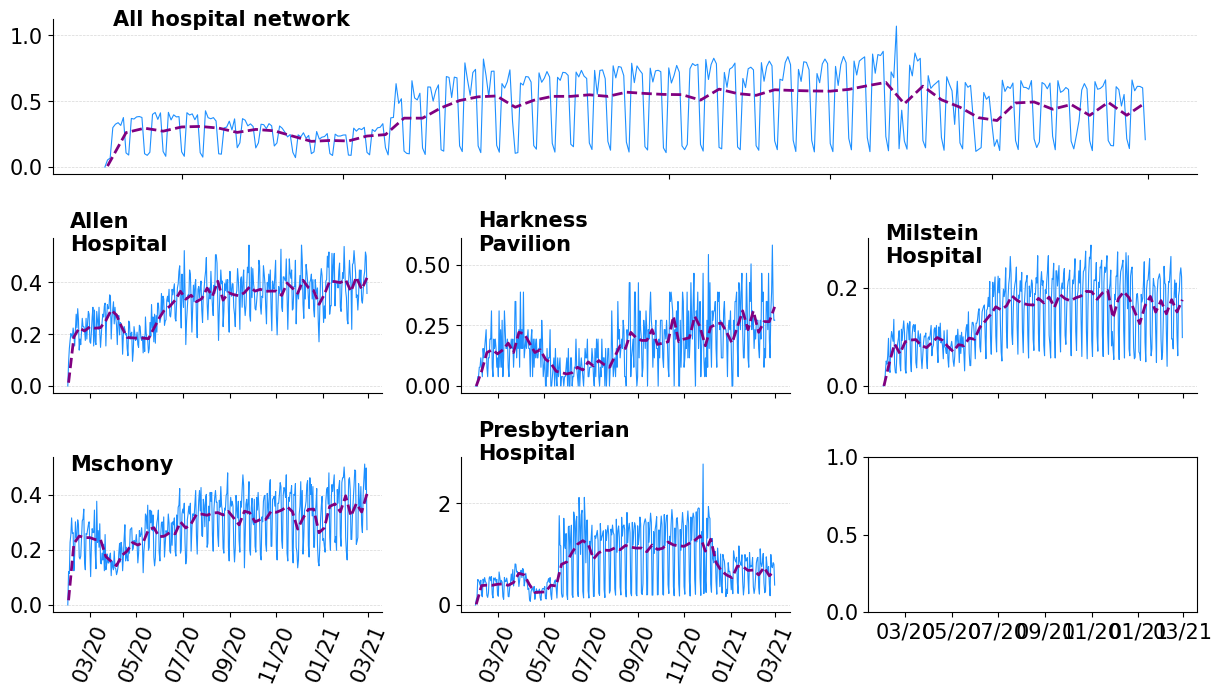

In [21]:
from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt


fig, axes = plt.subplot_mosaic([["hospital", "hospital", "hospital"],
                               [selected_buildings[0], selected_buildings[1], selected_buildings[2]],
                               [selected_buildings[3], selected_buildings[4], selected_buildings[5]]],
                              figsize=(12.5, 7.2), sharex=True, sharey=False)

hosp_df = buildings_plt_df.groupby(['date']).sum().reset_index()
axes["hospital"].plot(hosp_df.date, hosp_df.num_discharged / (pop.sum()), color="dodgerblue", lw=0.8)

hosp_df        = hosp_df.set_index("date").resample("W-Sun").sum().reset_index()
axes["hospital"].plot(hosp_df.date, hosp_df.num_discharged / (7*pop.sum()), color="purple", lw=2, ls="--")

axes["hospital"].tick_params(which='both', axis='x', labelrotation=75)
axes["hospital"].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
axes["hospital"].spines['right'].set_visible(False)
axes["hospital"].spines['top'].set_visible(False)
axes["hospital"].set_ylabel(None)
axes["hospital"].set_xlabel(None)
axes["hospital"].grid(axis='y', alpha=0.5, lw=0.5, ls="--")
axes["hospital"].text(x  = 18296.0,
                      y  = axes["hospital"].get_ylim()[1]-0.05,
                      s          = "All hospital network",
                      fontweight = "bold")

for idx_b in range(5):
    axi      = axes[selected_buildings[idx_b]]
    building = selected_buildings[idx_b]
    b_df     = buildings_plt_df[buildings_plt_df.building2 == building]
    axi.plot(b_df.date, b_df.num_discharged / pop[building], color="dodgerblue", lw=0.8)

    b_df        = b_df.set_index("date").resample("W-Sun").sum().reset_index()
    axi.plot(b_df.date, b_df.num_discharged / (7*pop[building]), color="purple", lw=2, ls="--")

    axi.tick_params(which='both', axis='x', labelrotation=67.5)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    axi.text(x = 18296.0,
            y  = axi.get_ylim()[1]-0.05,
            s          = "\n".join(building.split(" ")),
            fontweight = "bold")
    axi.grid(axis='y', alpha=0.5, lw=0.5, ls="--")

plt.tight_layout()